# 1 Setup

## 1.1 Import some great packages


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
#progress bar
from tqdm.notebook import tqdm

## 1.2 Load the data from organizer Google drive

In [3]:
def folder_download(folder_id):
  # authenticate
  from google.colab import auth
  auth.authenticate_user()
  # get folder_name
  from googleapiclient.discovery import build
  service = build('drive', 'v3')
  folder_name = service.files().get(fileId=folder_id).execute()['name']
  # import library and download
  !wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py
  from download import download_folder
  download_folder(service, folder_id, './', folder_name)
  return folder_name

folder_download('1g58xFQ9aDcTPetma4blzVTQYX-QKkzNf')

1JXVxKJgHVoO6d8Tw1YvUaVUo5icYP-qz Data_static_logs.csv text/csv (1/6)
Download 100%.
1JwEKs63e0g26utJIeZkmZC6IpCFtxiS4 Data_wrangling_GtX.ipynb application/vnd.google.colaboratory (2/6)
Download 100%.
1fZJeOSiSNJhEflCys-SU89DYVUNMGyx_ Duvernay application/vnd.google-apps.folder (3/6)
1nSduAg1dRkkuS8TLHDRo_W8pHmM__2Zn Duvernay application/vnd.google-apps.folder (1/1)
1Q7JqL9OEOQ6ElqgngcKHiuKGiVJgg3Xd Duvenay TrueTemp_Train.xlsx application/vnd.openxmlformats-officedocument.spreadsheetml.sheet (1/7)
Download 100%.
1NtpKfoCBu8Ov4-rIsMftH2vfF1nsfBOb Duvernay DST BHT for SPE April 20 2021.xlsx application/vnd.openxmlformats-officedocument.spreadsheetml.sheet (2/7)
Download 100%.
1bCdzvZtZ72Kk8w_wry-p07URdiEIkPg9 Duvernay DST Pressures SPE May 2 2021.xlsx application/vnd.openxmlformats-officedocument.spreadsheetml.sheet (3/7)
Download 100%.
1S47FKEnpxJZjcxr_vmTM4DGnm4G2mj4X Duvernay formation tops SPE April 20 2021.xlsx application/vnd.openxmlformats-officedocument.spreadsheetml.sheet (4/7)


'Data for Datathon'

In [4]:
# unzip some files
!mkdir clean_las_files
! cd Data\ for\ Datathon && unzip well_log_files.zip -d /content/clean_las_files

Archive:  well_log_files.zip
   creating: /content/clean_las_files/Clean_LAS/
  inflating: /content/clean_las_files/Clean_LAS/CA100010107020W500_3067458_00001H5337365_W.LAS  
  inflating: /content/clean_las_files/Clean_LAS/CA100010107020W500_3067458_00992H4184542.LAS  
  inflating: /content/clean_las_files/Clean_LAS/CA100010608109W500_3067458_00002H1405557_W.LAS  
  inflating: /content/clean_las_files/Clean_LAS/CA100010608109W500_3067458_00546H1280753.LAS  
  inflating: /content/clean_las_files/Clean_LAS/CA100010904012W500_3067458_00003H4344853_W.LAS  
  inflating: /content/clean_las_files/Clean_LAS/CA100010904012W500_3067458_00615H4348337.LAS  
  inflating: /content/clean_las_files/Clean_LAS/CA100011206021W400_3067458_00004H4246284_W.LAS  
  inflating: /content/clean_las_files/Clean_LAS/CA100011206021W400_3067458_01014H4242150.LAS  
  inflating: /content/clean_las_files/Clean_LAS/CA100011506915W500_3067458_00005H3910764_W.LAS  
  inflating: /content/clean_las_files/Clean_LAS/CA1000115

In [5]:
# set paths of different subdirectories
dir_eaglebine = 'Data for Datathon/Eaglebine/Eaglebine/'
dir_duvernay = 'Data for Datathon/Duvernay/Duvernay/'

# 2 Organize Eaglebine temperature data

## 2.1 read in BHT

In [6]:
Eaglebine_BHT = pd.read_excel(dir_eaglebine+'Eaglebine BHT TSC data for SPE April 21 2020.xlsx')
Eaglebine_BHT['TempC_BHT'] = (Eaglebine_BHT['BHTorMRT (maximum recorded temperature) oF'] - 32) * (5./9.)
Eaglebine_BHT.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889


In [7]:
print("number of unique wells: " + str(len(pd.unique(Eaglebine_BHT['UWI']))))

number of unique wells: 324


## 2.2 Read in Eaglebine synthetic "true formation temperature"

In [8]:
Eaglebine_Truth = pd.read_excel(dir_eaglebine+'Eaglebine TrueTemp_Train2.xlsx')
Eaglebine_Truth.head()

,UWI,Depth sub-sea (feet),True Temperature (oF)
0,42013301410000,-350,70.33
1,42013301410000,-300,70.33
2,42013301410000,-250,70.33
3,42013301410000,-200,71.49
4,42013301410000,-150,72.66


In [9]:
# convert to Celsius
Eaglebine_Truth['TempTrue_degC'] = (Eaglebine_Truth['True Temperature   (oF)'] - 32) * (5./9.)

In [10]:
print("number of unique wells in Eaglebine in training set: " + str(len(pd.unique(Eaglebine_Truth['UWI']))))

number of unique wells in Eaglebine in training set: 243


## 2.3 Combine measured BHT and true temperature

In [11]:
Eaglebine_Combined = Eaglebine_BHT.merge(Eaglebine_Truth, on='UWI', how='left')

In [12]:
# only keep from the synthetic data, the temperature at the elevation closest to the model
Eaglebine_Combined['diff_depth'] = Eaglebine_Combined['Depth sub-sea (feet)']-Eaglebine_Combined['BHT_below sea level (ft)']
Eaglebine_Combined['diff_depth_abs'] = np.abs(Eaglebine_Combined['diff_depth'])
idx = Eaglebine_Combined.groupby(['UWI'])['diff_depth_abs'].transform(min) == Eaglebine_Combined['diff_depth_abs']
TrueTempUWI = Eaglebine_Combined.loc[idx, ['UWI', 'diff_depth_abs', 'TempTrue_degC']]
TrueTempUWI = TrueTempUWI.copy(deep=True)
Eaglebine_Combined_cln = Eaglebine_BHT.merge(TrueTempUWI, on='UWI', how='left')
Eaglebine_Combined_cln.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,diff_depth_abs,TempTrue_degC
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667,22.50,141.555556
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222,4.00,132.038889
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556,17.00,89.161111
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667,6.00,107.961111
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889,9.48,133.722222


In [13]:
len(Eaglebine_Combined_cln)

324

## 2.4 Read in static temperature information and merge into dataset

In [14]:
Static_log_temp = pd.read_csv('Data for Datathon/Data_static_logs.csv')
Static_log_temp.head()

,Well_ID,Depth (ft),Temp (degC),Field
0,42013301930000,10700.0,132.778000,Eaglebine
1,42041305800000,7360.0,82.777778,Eaglebine
2,42041311700000,7828.0,118.888889,Eaglebine
3,42041311980000,7954.0,105.000000,Eaglebine
4,42051305380000,8380.0,111.111111,Eaglebine


In [15]:
Eaglebine_Combined_cln['UWI'] = Eaglebine_Combined_cln['UWI'].astype(str)
Eaglebine_Combined_cln = Eaglebine_Combined_cln.copy(deep=True)
Eaglebine_Combined_cln['TrueTemp_datasource_syn'] = 'synthetic'
Static_log_temp['TrueTemp_datasource_stat'] = 'static_temp_logs'
Eaglebine_Combined_stat = Eaglebine_Combined_cln.merge(Static_log_temp, left_on='UWI',right_on='Well_ID', how='left')

In [16]:
# Coalesce columns together with priority for true temperature measurements
Eaglebine_Combined_stat['TempC_Fin'] = Eaglebine_Combined_stat['Temp (degC)'].fillna(Eaglebine_Combined_stat['TempTrue_degC'])
Eaglebine_Combined_stat['TrueTemp_datasource'] = Eaglebine_Combined_stat['TrueTemp_datasource_stat'].fillna(Eaglebine_Combined_stat['TrueTemp_datasource_syn'])
Eaglebine_Combined_stat.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,diff_depth_abs,TempTrue_degC,TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin,TrueTemp_datasource
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667,22.50,141.555556,synthetic,NaN,NaN,NaN,NaN,NaN,141.555556,synthetic
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222,4.00,132.038889,synthetic,42013301930000,10700.0,132.778,Eaglebine,static_temp_logs,132.778000,static_temp_logs
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556,17.00,89.161111,synthetic,NaN,NaN,NaN,NaN,NaN,89.161111,synthetic
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667,6.00,107.961111,synthetic,NaN,NaN,NaN,NaN,NaN,107.961111,synthetic
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889,9.48,133.722222,synthetic,NaN,NaN,NaN,NaN,NaN,133.722222,synthetic


## 2.5 plot the eaglebine temperature data

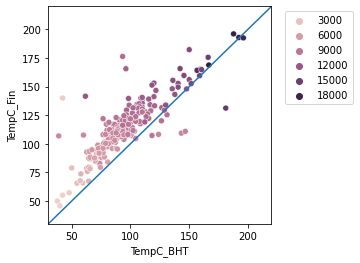

In [17]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Eaglebine_Combined_stat, x="TempC_BHT", y="TempC_Fin", hue='BHT_below sea level (ft)', ax=ax)

ax.set_xlim([30, 220])
ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# 3 Organize Duvernay temperature data

## 3.1 Read in DST BHT input and "true temp" synthetic data

In [18]:
Duvernay_Truth = pd.read_excel(dir_duvernay+'Duvenay TrueTemp_Train.xlsx')
Duvernay_DST = pd.read_excel(dir_duvernay+'Duvernay DST BHT for SPE April 20 2021.xlsx')
Duvernay_Truth.head()

,UWI,Depths subsea (m),True Temperature (oC)
0,100010107020W500,-720,2.53
1,100010107020W500,-700,2.54
2,100010107020W500,-680,2.54
3,100010107020W500,-660,3.30
4,100010107020W500,-640,4.06


In [19]:
# add in an extra column calculating the depth sub sea (elevation-depth)*-1 
Duvernay_DST['Depth_SS(m)']=-1*(Duvernay_DST['elevation M above sea level']-(Duvernay_DST['DST Start Depth (MD) (m)']+Duvernay_DST['DST End Depth (MD) (m)'])/2)
Duvernay_DST.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,elevation M above sea level,UWI,Depth_SS(m)
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0
1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,NaN,645.6,100010608109W500,1044.4
2,100010904012W500,3698.0,3718.0,104.40,30798,LRT,N,1,Melkton,NaN,1283.8,100010904012W500,2424.2
3,100011206021W400,822.0,825.0,29.00,29543,DST,N,4,Dwintrbrn,NaN,651.6,100011206021W400,171.9
4,100011506915W500,1801.0,1818.0,64.00,30760,DST,N,4,Dwabamun,NaN,873.1,100011506915W500,936.4


In [20]:
# merge
Duvernay_Combined = Duvernay_DST.merge(Duvernay_Truth, on='UWI', how='left')
Duvernay_Combined.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,elevation M above sea level,UWI,Depth_SS(m),Depths subsea (m),True Temperature (oC)
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-720.0,2.53
1,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-700.0,2.54
2,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-680.0,2.54
3,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-660.0,3.30
4,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-640.0,4.06


In [21]:
# keep only the synthetic model temperature data for the relevant depths for which there is BHT measurement
Duvernay_Combined['diff_depth'] = Duvernay_Combined['Depth_SS(m)']-Duvernay_Combined['Depths subsea (m)']
Duvernay_Combined['diff_depth_abs'] = np.abs(Duvernay_Combined['diff_depth'])
idx = Duvernay_Combined.groupby(['UWI'])['diff_depth_abs'].transform(min) == Duvernay_Combined['diff_depth_abs']

TrueTempUWI = Duvernay_Combined.loc[idx, ['UWI', 'diff_depth_abs', 'True Temperature (oC)']]
TrueTempUWI = TrueTempUWI.copy(deep=True)
Duvernay_Combined_cln = Duvernay_DST.merge(TrueTempUWI, on='UWI', how='left')
Duvernay_Combined_cln = Duvernay_Combined_cln.drop_duplicates(['UWI'])
Duvernay_Combined_cln.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,elevation M above sea level,UWI,Depth_SS(m),diff_depth_abs,True Temperature (oC)
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,4.0,60.97
1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,NaN,645.6,100010608109W500,1044.4,4.4,63.98
2,100010904012W500,3698.0,3718.0,104.40,30798,LRT,N,1,Melkton,NaN,1283.8,100010904012W500,2424.2,NaN,NaN
3,100011206021W400,822.0,825.0,29.00,29543,DST,N,4,Dwintrbrn,NaN,651.6,100011206021W400,171.9,8.1,39.07
4,100011506915W500,1801.0,1818.0,64.00,30760,DST,N,4,Dwabamun,NaN,873.1,100011506915W500,936.4,3.6,69.47


In [22]:
len(Duvernay_Combined_cln)

512

## 3.2 Merge in static temperature log data

In [23]:
Duvernay_Combined_cln['UWI'] = Duvernay_Combined_cln['UWI'].astype(str)
Duvernay_Combined_cln = Duvernay_Combined_cln.copy(deep=True)
Duvernay_Combined_cln['TrueTemp_datasource_syn'] = 'synthetic'
Static_log_temp['TrueTemp_datasource_stat'] = 'static_temp_logs'
Duvernay_Combined_stat = Duvernay_Combined_cln.merge(Static_log_temp, left_on='UWI',right_on='Well_ID', how='left')

In [24]:
Static_log_temp.head()

,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat
0,42013301930000,10700.0,132.778000,Eaglebine,static_temp_logs
1,42041305800000,7360.0,82.777778,Eaglebine,static_temp_logs
2,42041311700000,7828.0,118.888889,Eaglebine,static_temp_logs
3,42041311980000,7954.0,105.000000,Eaglebine,static_temp_logs
4,42051305380000,8380.0,111.111111,Eaglebine,static_temp_logs


In [25]:
# Coalesce columns together with priority for true temperature measurements
Duvernay_Combined_stat['TempC_Fin'] = Duvernay_Combined_stat['Temp (degC)'].fillna(Duvernay_Combined_stat['True Temperature (oC)'])
Duvernay_Combined_stat['TrueTemp_datasource'] = Duvernay_Combined_stat['TrueTemp_datasource_stat'].fillna(Duvernay_Combined_stat['TrueTemp_datasource_syn'])

Duvernay_Combined_stat.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,elevation M above sea level,UWI,Depth_SS(m),diff_depth_abs,True Temperature (oC),TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin,TrueTemp_datasource
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,4.0,60.97,synthetic,NaN,NaN,NaN,NaN,NaN,60.97,synthetic
1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,NaN,645.6,100010608109W500,1044.4,4.4,63.98,synthetic,NaN,NaN,NaN,NaN,NaN,63.98,synthetic
2,100010904012W500,3698.0,3718.0,104.40,30798,LRT,N,1,Melkton,NaN,1283.8,100010904012W500,2424.2,NaN,NaN,synthetic,NaN,NaN,NaN,NaN,NaN,NaN,synthetic
3,100011206021W400,822.0,825.0,29.00,29543,DST,N,4,Dwintrbrn,NaN,651.6,100011206021W400,171.9,8.1,39.07,synthetic,NaN,NaN,NaN,NaN,NaN,39.07,synthetic
4,100011506915W500,1801.0,1818.0,64.00,30760,DST,N,4,Dwabamun,NaN,873.1,100011506915W500,936.4,3.6,69.47,synthetic,NaN,NaN,NaN,NaN,NaN,69.47,synthetic


## 3.3 Plot the temp data

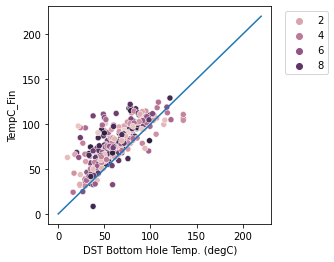

In [26]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Duvernay_Combined_stat, 
                x="DST Bottom Hole Temp. (degC)",
                y="TempC_Fin",
                hue='diff_depth_abs', ax=ax)

#ax.set_xlim([30, 220])
#ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# 4 Combine Eaglebine and Duvernay temperature datasets

In [27]:
Duvernay = Duvernay_Combined_stat[['UWI', 'DST Bottom Hole Temp. (degC)', 'TempC_Fin','Depth_SS(m)']]
Duvernay = Duvernay.rename(columns={'DST Bottom Hole Temp. (degC)': 'BHT', 'TempC_Fin': 'TrueTemp'})
Duvernay['Field'] = 'Duvernay'

Eaglebine = Eaglebine_Combined_stat[['UWI', 'TempC_BHT', 'TempC_Fin', 'TD (ft)']]
Eaglebine = Eaglebine.rename(columns={'TempC_BHT': 'BHT', 'TempC_Fin': 'TrueTemp'})
Eaglebine['Field'] = 'Eaglebine'

combined_temperature = pd.concat((Duvernay, Eaglebine))
combined_temperature.head()

,UWI,BHT,TrueTemp,Depth_SS(m),Field,TD (ft)
0,100010107020W500,48.33,60.97,716.0,Duvernay,NaN
1,100010608109W500,34.26,63.98,1044.4,Duvernay,NaN
2,100010904012W500,104.40,NaN,2424.2,Duvernay,NaN
3,100011206021W400,29.00,39.07,171.9,Duvernay,NaN
4,100011506915W500,64.00,69.47,936.4,Duvernay,NaN


In [28]:
# save this structured data to file
! mkdir StructuredData
combined_temperature.to_csv('StructuredData/combined_temperature.csv')

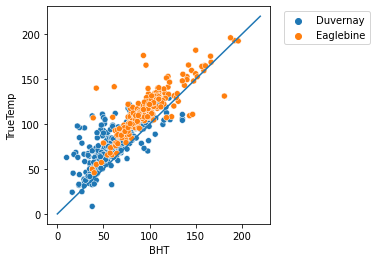

In [29]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=combined_temperature, 
                x="BHT",
                y="TrueTemp",
                hue='Field', ax=ax)

ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# 5 Organize Mud-weight, formation, well header, and production data

This section consolidates the files provided by GTS. List of imported files and the dataframe names:

- Eaglebine mud weight SPE April 21 2021.xlsx: **EB_MW**
- Eaglebine formation tops SPE April 20 2021.xlsx: **EB_FT**
- Eaglebine well headers SPE April 21 2021.xlsx: **EB_WH**
- SPE Eaglebine production summary April 20 2021.xlsx: **EB_PS**
- Duvernay formation tops SPE April 20 2021.xlsx: **DV_FT**
- Duvernay well headers SPE April 21 2021 .xlsx: **DV_WH**
- SPE Duvernay production summary April 20 2021.xlsx: **DV_PS**

**Workflow: add the multiple entries as attributes**

1. read the excel file into a dataframe. Leave the indexing out at this stage.
1. for each well number (Well_Id), tag the multiple entries in a new column.
    - New column name: 'attribute_' + the name of the column with multiple entries.
    - Tag: name of the column with multiple entries + sequential number for multiple entries in that column
1. reshape the featured table to pivot on the attribute
1. check for dupblicates on 'Well_Id' after reshaping. If duplicates exist inspect all columns for each well. If no duplicates, it's ready for merge


(Thanks Korang Modaressi for code)

In [30]:
files_to_upload = {'file': ['Eaglebine mud weight SPE April 21 2021.xlsx', 
                         'Eaglebine formation tops SPE April 20 2021.xlsx',
                         'Eaglebine well headers SPE April 21 2021.xlsx',
                         'SPE Eaglebine production summary April 20 2021.xlsx',
                         'Duvernay formation tops SPE April 20 2021.xlsx',
                         'Duvernay well headers SPE April 21 2021 .xlsx',
                         'SPE Duvernay production summary April 20 2021.xlsx'],
                  'df_name': ['EB_MW', 'EB_FT', 'EB_WH', 'EB_PS', 'DV_FT', 'DV_WH', 'DV_PS']}
files_to_upload['flat_df_name'] = [str(c) + '_flat' for c in files_to_upload['df_name']]
print(files_to_upload['flat_df_name'])
print(files_to_upload['df_name'][0][:2])

['EB_MW_flat', 'EB_FT_flat', 'EB_WH_flat', 'EB_PS_flat', 'DV_FT_flat', 'DV_WH_flat', 'DV_PS_flat']
EB


In [31]:
EB_MW = pd.read_excel(dir_eaglebine+"Eaglebine mud weight SPE April 21 2021.xlsx")
display(EB_MW.head())
EB_MW.columns = [c.strip() for c in EB_MW.columns.values.tolist()]
EB_MW.rename(columns = {'UWI': 'Well_Id'}, inplace = True)

,UWI,TD,KB,Mud Wt,MW@Depth(KB)
0,42013301410000,19629,327.5,9.3,4404
1,42013301410000,19629,327.5,11.9,12550
2,42013301410000,19629,327.5,11.2,12650
3,42013301410000,19629,327.5,11.9,12650
4,42013301410000,19629,327.5,11.9,14390


In [32]:
EB_FT = pd.read_excel(dir_eaglebine+"Eaglebine formation tops SPE April 20 2021.xlsx")
display(EB_FT.head())
EB_FT.columns = [c.strip() for c in EB_FT.columns.values.tolist()]
EB_FT.rename(columns = {'UWI': 'Well_Id'}, inplace = True)

,UWI,Bottom_Hole_Location_X,Bottom_Hole_Location_Y,Elevation(f),Elevation_Reference,Latitude,Longitude,Total_Depth(f),X(f),Y(f),01_Wilcox_MD_ft,02_Midway_MD_ft,03_Navarro_MD_ft,04_Taylor_MD_ft,05_Anacacho_MD_ft,06_Austin_Chalk_MD_ft,07_Upper_Eagle_Ford_MD_ft,08_Lower_Eagle_Ford_MD_ft,09_Woodbine_MD_ft,10_Maness_MD_ft,11_Buda_MD_ft,12_Del_Rio_MD_ft,13_Georgetown_MD_ft,14_Edwards_MD_ft,15_Glen_Rose_MD_ft,16_Pearsal_MD_ft,17_James_Cow_Creek_MD_ft,18_Sligo_MD_ft,19_Cotton_Valley_MD_ft
0,42013301410000,2170169.05,311696.26,328.0,KB,28.689529,-98.469238,0,2170169.05,311696.26,1464.64,4455.92,4927.92,7608.13,9164.50,9457.17,9558.71,9609.42,0.0,0.0,9712.58,9809.80,9862.60,9942.73,10796.27,12251.06,12534.95,12718.48,0.0
1,42013301930000,2253601.52,345032.51,379.0,KB,28.779921,-98.208313,0,2253601.52,345032.51,0.00,0.00,0.00,0.00,9933.17,10039.33,10127.58,10175.75,0.0,0.0,10280.42,10366.00,10405.21,0.00,0.00,0.00,0.00,0.00,0.0
2,42013302760000,2184830.73,422595.91,442.0,KB,28.994360,-98.421799,6168,2184830.73,422595.91,0.00,3553.31,4004.63,0.00,5521.92,5758.25,6024.93,6047.04,0.0,0.0,6100.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
3,42013305480000,2225271.51,411448.83,392.0,KB,28.963091,-98.295502,0,2225271.51,411448.83,0.00,0.00,0.00,0.00,7336.83,7530.67,7676.58,7735.83,0.0,0.0,7807.00,7908.82,7964.25,0.00,0.00,0.00,0.00,0.00,0.0
4,42013310190000,2270478.34,358777.49,491.0,KB,28.817400,-98.155319,0,2270478.34,358777.49,0.00,0.00,0.00,0.00,10062.17,10164.00,10254.50,10304.83,0.0,0.0,10393.50,10469.50,10503.75,10566.88,0.00,0.00,0.00,0.00,0.0


In [33]:
EB_WH = pd.read_excel(dir_eaglebine+"Eaglebine well headers SPE April 21 2021.xlsx")
display(EB_WH.head())
EB_WH.rename(columns = {'displayapi': 'Well_Id'}, inplace = True)

,td,Elevation,ElevationDatum,displayapi,WGS84Latitude,WGS84Longitude,SurfLat,SurfLong,SurfaceLatitude_NAD83,SurfaceLongitude_NAD83,BottomLatitude_NAD83,BottomLongitude_NAD83,SurfaceLatitude_NAD27,SurfaceLongitude_NAD27,BottomLatitude_NAD27,BottomLongitude_NAD27
0,19635,338.68,KB,42013301410000,NaN,NaN,NaN,NaN,28.690101,-98.469817,28.690101,-98.469817,28.689839,-98.469523,28.689839,-98.469523
1,10775,384.59,KB,42013301930000,NaN,NaN,NaN,NaN,28.780042,-98.208395,28.780042,-98.208396,28.779784,-98.208109,28.779784,-98.208109
2,6175,442.00,KB,42013302760000,NaN,NaN,NaN,NaN,28.994810,-98.422767,28.994810,-98.422767,28.994561,-98.422475,28.994561,-98.422475
3,8198,392.00,KB,42013305480000,NaN,NaN,NaN,NaN,28.963395,-98.295961,28.963395,-98.295961,28.963144,-98.295673,28.963144,-98.295672
4,11000,493.23,KB,42013310190000,NaN,NaN,NaN,NaN,28.817939,-98.155472,28.817939,-98.155472,28.817682,-98.155187,28.817682,-98.155187


In [34]:
EB_PS = pd.read_excel(dir_eaglebine+"SPE Eaglebine production summary April 20 2021.xlsx")
display(EB_PS.head())
EB_PS.columns = [c.strip() for c in EB_PS.columns.values.tolist()]
EB_PS.rename(columns = {'API': 'Well_Id'}, inplace = True)

,API,Measured Depth (ft),Total Vertical Depth (ft),Spud Date,Completion Date,First Production Month,Elevation,Oil Total Cum (bbl),Gas Total Cum (mcf),Water Total Cum (bbl),GOR Total Average,Plug Date,TD Date,Drilling Days,Last Production Month,Gas Maximum (mcf),Gas Maximum Date,Oil Maximum (bbl),Oil Maximum Date,Water Maximum (bbl),Water Maximum Date,Liquid Injection Cum (bbl),Gas Injection Cum (mcf)
0,42013301410000,NaN,NaN,1971-02-14,NaT,NaT,NaN,NaN,NaN,NaN,NaN,1972-02-18,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaN
1,42013301930000,NaN,10775.0,NaT,1972-07-22,1972-07-01,363 GL,6140.000,8702967.000,1002330.677,1417421.336,NaT,NaT,NaN,2020-12-01,98093.000,1972-10-01,271.000,2010-03-01,11771.16,1972-10-01,NaN,NaN
2,42013302760000,NaN,6168.0,NaT,1975-07-28,1975-07-01,409 GL,1929.332,7.992,0.000,4.142,1987-07-23,NaT,NaN,1981-02-01,0.333,1975-07-01,533.333,1975-08-01,0.00,1975-07-01,NaN,NaN
3,42013305480000,NaN,NaN,1977-01-23,1977-02-24,1977-02-01,267 GL,0.000,10067.000,0.000,NaN,1983-12-15,NaT,NaN,1979-08-01,1464.000,1977-04-01,0.000,1977-02-01,0.00,1977-02-01,NaN,NaN
4,42013310190000,NaN,11000.0,1980-08-13,1980-10-25,1980-11-01,NaN,4424.000,6610808.000,47611.388,1494305.606,NaT,NaT,NaN,2020-12-01,63674.000,1981-08-01,108.000,1992-10-01,870.74,1998-05-01,NaN,NaN


In [35]:
DV_FT = pd.read_excel(dir_duvernay+"Duvernay formation tops SPE April 20 2021.xlsx")
display(DV_FT.head())
DV_FT.columns = [c.strip() for c in DV_FT.columns.values.tolist()]
DV_FT.rename(columns = {'UWI': 'Well_Id'}, inplace = True)

,UWI,Bottom Hole Location X_m_NAD27_Zone 11N (120 W to 114 W),Bottom Hole Location Y_m_NAD27_Zone 11N (120 W to 114 W),Elevation(m above sea level),01_Battle (Surbiton)[SSTVD] (m),02_Lea_Park (Surbiton)[SSTVD] (m),03_1st_White_Speckled_Shale (Surbiton)[SSTVD] (m),04_2nd_White_Speckled_Shale (Surbiton)[SSTVD] (m),05_Fish_scales (Surbiton)[SSTVD] (m),06_Mannville_Top (Surbiton)[SSTVD] (m),07_Ostracod_Beds (Surbiton)[SSTVD] (m),08_Jurassic_Top (Surbiton)[SSTVD] (m),09_Montney_Top (Surbiton)[SSTVD] (m),10_Permian_Top (Surbiton)[SSTVD] (m),11_Wabamun (Surbiton)[SSTVD] (m),12_Winterburn (Surbiton)[SSTVD] (m),13_Woodbend (Surbiton)[SSTVD] (m),14_Duvernay_Top (Surbiton)[SSTVD] (m),15_Beaverhill (Surbiton)[SSTVD] (m),16_Elk_Point (Surbiton)[SSTVD] (m),17_Precambrian Basement (Surbiton)[SSTVD] (m)
0,100010107020W500,506245.60,6097691.89,701.0,NaN,NaN,189.50,-3.4,-214.00,-307.0,-607.7,-627.3,-713.3,NaN,-1271.1,-1508.8,-1605.1,-1900.50,-1937.3,-2044.3,NaN
1,100010608109W500,600487.16,6205637.53,645.6,NaN,NaN,NaN,NaN,390.30,342.5,NaN,NaN,NaN,NaN,-206.4,-483.9,-604.7,-842.77,-895.4,-1042.5,-1078.4
2,100010904012W500,591372.37,5808846.49,1283.8,NaN,-1081.79,-1265.89,-1741.2,-1984.70,-2034.7,-2231.2,-2335.2,NaN,NaN,-2735.2,-3011.2,-3082.2,-3293.20,-3340.2,-3504.7,NaN
3,100011206021W400,760983.75,6009309.66,651.6,NaN,464.00,323.30,190.1,91.10,35.6,-125.1,NaN,NaN,NaN,NaN,-168.4,-246.4,-422.40,-579.4,-811.4,NaN
4,100011506915W500,552047.78,6091428.82,873.1,NaN,293.98,223.10,NaN,-129.94,-213.7,-461.9,NaN,NaN,NaN,-919.8,-1164.7,-1279.7,-1557.30,-1602.2,-1744.9,NaN


In [36]:
DV_WH = pd.read_excel(dir_duvernay+"Duvernay well headers SPE April 21 2021 .xlsx")
display(DV_WH.head())
DV_WH.columns = [c.strip() for c in DV_WH.columns.values.tolist()]
DV_WH.rename(columns = {'UWI': 'Well_Id'}, inplace = True)

,UWI,Elevation Meters,ElevationDatum,TD meters,SurfaceLatitude_NAD83,SurfaceLongitude_NAD83,BottomLatitude_NAD83,BottomLongitude_NAD83,SurfaceLatitude_NAD27,SurfaceLongitude_NAD27,BottomLatitude_NAD27,BottomLongitude_NAD27
0,100072507623W500,555.7,KB,2545.0,55.613640,-117.423800,55.613640,-117.423800,55.613640,-117.423800,55.613640,-117.423800
1,100062007823W500,560.9,KB,2430.0,55.770872,-117.537674,55.770872,-117.537674,55.770872,-117.537674,55.770872,-117.537674
2,100052107723W500,558.4,KB,2515.5,55.683723,-117.516168,55.683723,-117.516168,55.683723,-117.516168,55.683723,-117.516168
3,100061307518W500,631.4,KB,2411.0,55.494600,-116.653606,55.494600,-116.653606,55.494600,-116.653606,55.494600,-116.653606
4,100070907618W500,627.0,KB,2408.0,55.566965,-116.726243,55.566965,-116.726243,55.566965,-116.726243,55.566965,-116.726243


In [37]:
DV_PS = pd.read_excel(dir_duvernay+"SPE Duvernay production summary April 20 2021.xlsx")
display(DV_PS.head())
DV_PS.columns = [c.strip() for c in DV_PS.columns.values.tolist()]
DV_PS.rename(columns = {'API': 'Well_Id'}, inplace = True)

,API,Measured Depth (ft),Total Vertical Depth (ft),Spud Date,Completion Date,First Production Month,Elevation,Oil Total Cum (bbl),Gas Total Cum (mcf),Water Total Cum (bbl),GOR Total Average,Plug Date,First Production Date,Elevation Drill Floor (ft),Elevation Ground (ft),Elevation Kelly Bushing (ft),Last Production Month,Gas Maximum (mcf),Gas Maximum Date,Oil Maximum (bbl),Oil Maximum Date,Water Maximum (bbl),Water Maximum Date,Yield Total Average
0,100010107020W500,9081,9081,1971-03-11,NaT,NaT,2287 GL,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2287,2300,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
1,100010608109W500,5725,5725,1992-02-03,1993-01-18,1992-05-01,2103 GL,3422.286,2722.761,390.597,795.597,NaN,1992-05-22,NaN,2103,2119,1992-08-01,1084.16,1992-07-01,1639.125,1992-05-01,351.6,1992-05-01,1256.918
2,100010904012W500,15797,15797,1983-12-29,NaT,NaT,4186 GL,NaN,NaN,NaN,NaN,NaN,NaT,NaN,4186,4213,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
3,100011206021W400,4895,4895,1980-11-03,NaT,NaT,2123 GL,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2123,2139,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
4,100011506915W500,8891,8891,1984-02-21,NaT,NaT,2844 GL,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2844,2864,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN


In [38]:
# Loop thorugh each well (Well_Id), convert each column into ndarray with Well_Id as key
# Useful functions definitions
''' list the unique well identifiers (Well_Id) in the table and the number of rows for each. The new dataframe will be used to populate the columns of the wide table'''
def wells_and_attributes(df):
    well_data = df
    columns = well_data.columns
    well_data_count = well_data['Well_Id'].value_counts()
    wells = well_data_count.index
    return well_data, wells, columns

''' 
The 'entry_to_attr' function collects the unique Well_Id and pivots entries under each Well_Id into attributes. 
The loop check for each unique well number in well_data_count, loops through columns and pivots the values in each column into a dataframe.
The name of the current column is used as prefix with an underscore "columnname_" joined with suffix as the index (from 0) of the entries for each well. 
The extracted variables are turned into dataframe and is concatenated with the existing dataframe from previous loop. 
'''
def entry_to_attr(df):
    well_data_flat = pd.DataFrame() #dataframe for storing well records after change to wide format
    well_data, wells, columns = wells_and_attributes(df) #read 'wells_and_attributes' function description
    for well in wells:
        well_data_intermediate_flat = pd.DataFrame() #temporary dataframe to store pivoted entries to new attributes for each original column
        well_data_filtered = well_data[well_data['Well_Id'] == well] #filterd for 'well' to start pivoting to new attributes
        #print(well_data_filtered)
        for column in columns: #pivots columns for each well into new attributes
            if column == 'Well_Id': #ignores the Well_Id and flattens othe columns
                continue
            else:
                att_vars = np.array(well_data_filtered[column]) #array containing entries in 'column' for 'well'
                att_count = len(att_vars) #number of entries in the array used for naming the new columns
                att_names = [column+"_"+str(x) for x in range(att_count)] #new column name with number of entries (att_count array's length) as suffix
                well_data_intermediate = pd.DataFrame(att_vars).T #intermediate flat table to be merged with the temporary dataframe
                well_data_intermediate.columns = att_names
                index = pd.Index([well], name = 'Well_Id')
                well_data_intermediate.index = index
                well_data_intermediate_flat = pd.concat([well_data_intermediate_flat, well_data_intermediate], axis = 1)
        well_data_flat = pd.concat([well_data_flat, well_data_intermediate_flat])
    return well_data_flat

In [39]:
'''
In this loop the entry_to_attr funciton is looped for the dataframes:
    'EB_MW', 'EB_FT', 'EB_WH', 'EB_PS', 'DV_FT', 'DV_WH', 'DV_PS'
The resulting wide-format dataframe is stored in a new datafram. 
The wide-format dataframes are concatenated into one dataframe with Well_ID as index
'''
dataframes = [EB_MW, EB_FT, EB_WH, EB_PS, DV_FT, DV_WH, DV_PS]
consolidated_well_data = pd.DataFrame()
cols = []
rows = []
# consolidated_well_data = pd.concat([consolidated_well_data, dataframes[0], dataframes[1], dataframes[2]])
for i in range(len(dataframes)): #
    well_data_flat = entry_to_attr(dataframes[i])
    well_data_flat['Basin'] = files_to_upload['df_name'][i][:2]
    well_data_flat.reset_index(inplace = True)
    well_data_flat.to_excel(str(str(files_to_upload['flat_df_name'][i]) + '.' + 'xlsx'))
    print(well_data_flat.shape)
    well_data_flat.set_index(['Well_Id', 'Basin'], inplace = True)
    consolidated_well_data = pd.concat([consolidated_well_data, well_data_flat], axis = 1)
consolidated_well_data.shape
display(consolidated_well_data.head())
print('the consolidated_well_data has {} rows and {} columns'.format(consolidated_well_data.shape[0], consolidated_well_data.shape[1]))

(316, 54)
(324, 30)
(324, 17)
(308, 90)
(512, 22)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/multi.py:3369: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  uniq_tuples = lib.fast_unique_multiple([self._values, other._values], sort=sort)


(512, 13)
(512, 25)


,,TD_0,TD_1,TD_2,TD_3,TD_4,TD_5,TD_6,TD_7,TD_8,TD_9,TD_10,TD_11,TD_12,KB_0,KB_1,KB_2,KB_3,KB_4,KB_5,KB_6,KB_7,KB_8,KB_9,KB_10,KB_11,KB_12,Mud Wt_0,Mud Wt_1,Mud Wt_2,Mud Wt_3,Mud Wt_4,Mud Wt_5,Mud Wt_6,Mud Wt_7,Mud Wt_8,Mud Wt_9,Mud Wt_10,Mud Wt_11,Mud Wt_12,MW@Depth(KB)_0,...,12_Winterburn (Surbiton)[SSTVD] (m)_0,13_Woodbend (Surbiton)[SSTVD] (m)_0,14_Duvernay_Top (Surbiton)[SSTVD] (m)_0,15_Beaverhill (Surbiton)[SSTVD] (m)_0,16_Elk_Point (Surbiton)[SSTVD] (m)_0,17_Precambrian Basement (Surbiton)[SSTVD] (m)_0,Elevation Meters_0,ElevationDatum_0,TD meters_0,SurfaceLatitude_NAD83_0,SurfaceLongitude_NAD83_0,BottomLatitude_NAD83_0,BottomLongitude_NAD83_0,SurfaceLatitude_NAD27_0,SurfaceLongitude_NAD27_0,BottomLatitude_NAD27_0,BottomLongitude_NAD27_0,Measured Depth (ft)_0,Total Vertical Depth (ft)_0,Spud Date_0,Completion Date_0,First Production Month_0,Elevation_0,Oil Total Cum (bbl)_0,Gas Total Cum (mcf)_0,Water Total Cum (bbl)_0,GOR Total Average_0,Plug Date_0,First Production Date_0,Elevation Drill Floor (ft)_0,Elevation Ground (ft)_0,Elevation Kelly Bushing (ft)_0,Last Production Month_0,Gas Maximum (mcf)_0,Gas Maximum Date_0,Oil Maximum (bbl)_0,Oil Maximum Date_0,Water Maximum (bbl)_0,Water Maximum Date_0,Yield Total Average_0
Well_Id,Basin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
42013301410000,EB,19629.0,19629.0,19629.0,19629.0,19629.0,19629.0,19629.0,19629.0,19629.0,19629.0,19629.0,NaN,NaN,327.50,327.5,327.5,327.5,327.5,327.5,327.5,327.5,327.5,327.5,327.5,NaN,NaN,9.3,11.9,11.2,11.9,11.9,12.0,11.9,16.5,17.1,19.0,19.1,NaN,NaN,4404.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
42013301930000,EB,10775.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,379.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10775.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
42013302760000,EB,6168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,442.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6175.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
42013305480000,EB,8198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,392.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8198.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
42013310190000,EB,11000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN


the consolidated_well_data has 836 rows and 237 columns


In [40]:
consolidated_well_data_no_index = consolidated_well_data.reset_index()
consolidated_well_data.to_csv('StructuredData/consolidated_well_data.csv')
consolidated_well_data.to_excel('StructuredData/consolidated_well_data.xlsx')

# 6 Organize LAS file

In [41]:
### Thanks to Pushpesh Sharma for writing this section

In [42]:
import os
!pip install lasio
import lasio

In [43]:
#Load all files at once into las and las_df to save time
folder='clean_las_files/Clean_LAS/'
all_files = os.listdir(folder)
n_files = len(all_files)

bad_files = []

las = {}
las_df = {}
mnemonics ={}
i=0
for filename in tqdm(os.listdir(folder)):
    i=i+1
    if filename.endswith(".LAS"):
        las[filename] = lasio.read(folder+'/'+filename)
        las_df[filename] = las[filename].df()
        mnemonics[filename] = las_df[filename].columns

In [44]:
#find out which well curves/logs are in each las file
listDF = []
for filename in tqdm(all_files):
    df = pd.DataFrame(columns = list(mnemonics[filename]), data = np.ones((1,len(mnemonics[filename]))))
    df['well_name']=filename
    listDF.append(df)

In [45]:
log_table=pd.concat(listDF)

In [46]:
# Here we can see which logs are in each well
log_table.head()

,ACED,CALDED,CALS1ED,CALSED,CALWS,CILDED,CONDWS,DCORED,DCORWS,DENWS,DPHILSED,DPOLSWS,DRESWS,DTED,DTWS,GRDED,GRNED,GRS1ED,GRSED,GRWS,ILD1ED,ILDED,ILMED,LL8ED,MRESWS,NEUTED,NEUTWS,RHOBED,SNED,SPR1ED,SPRED,SPWS,SRESWS,well_name,ILD,ILM,LL8,SPR,GRS,DT,...,CONDED,C13SED,RSFLED,DPHIDM,NPHIDM,DT1RRED,DT2RED,DT4SED,PORO_LS,PORS_DM,PORS_LS,VEL,TAU_1,TAU_2,DT_3,DNPHED,HPRAED,CIDPED,AF10ED,AF90ED,DPHZED,TNPHED,DPHI1ED,DNPH,HPRA,CALSDED,TENR1ED,DPOR_DM,NPOR_DM,C13S,RSFL,PHND_LS,LCAL,PEFS,NPHI_L,TENR_1,CALSD,CNLSSED,C11ED,C21ED
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CA100072103910W500_3067458_00213H5275672_W.LAS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA100162706309W500_3067458_00951H4339507.LAS,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,CA100060905918W500_3067458_00139H5275602_W.LAS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,CA100101608108W500_3067458_00300H1403106_W.LAS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,CA100023306507W500_3067458_00053H5351445_W.LAS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# see what are the most common log types
sumT = log_table.drop(columns=['well_name']).sum()
sumT.sort_values(ascending=False)

SPR       797.0
GRWS      660.0
DRESWS    657.0
CONDWS    656.0
CALWS     650.0
          ...  
CGRED       1.0
CNS         1.0
CDL         1.0
RLL3        1.0
C21ED       1.0
Length: 793, dtype: float64

In [48]:
# make a table of the log types available per well
for filename in all_files:
    las_df[filename] = las_df[filename].rename_axis('DEPT').reset_index()

In [49]:
# we can extract the gamma ray values [GRWS] at 
# regular intervals to add to the dataset (every 300 ft)
WellLog = 'GRWS'

select_depth = list(np.arange(300, 30300, 300))
new_las_df = {}
extracted_df = {}
j = 0
fncnt = 0
for filename in tqdm(all_files):
    fncnt = fncnt+1

    las_df[filename] = las_df[filename].sort_values(by='DEPT')
    p = las_df[filename]
    new_las_df[filename] = p[p['DEPT'].isin(select_depth)]
    if(WellLog not in list(new_las_df[filename].columns)):
      continue
    q = new_las_df[filename][WellLog]
    Depth = new_las_df[filename]['DEPT']
    
    concat_list = list()
    column_name = list()
    for i in range(0,q.shape[0]):
        concat_list.append(q.iloc[i])
        column_name.append(str(Depth.iloc[i])+'_'+WellLog)
        
    concat_array = np.array(concat_list)
    concat_array = np.reshape(concat_array,(1,len(concat_list)))
    df = pd.DataFrame(concat_array, columns=column_name)
    df['WellName'] = filename[2:16]
    if filename[-5] == 'W':
        df['LogType'] = 'Cleaned'
    else:
        df['LogType'] = 'Raw'
    extracted_df[j] = df
    j = j+1

In [50]:
LargeDF = pd.concat(extracted_df)
LargeDF.to_csv('StructuredData/LogData.csv')

# 7 Combine all data sources together

In [51]:
TemperatureData = pd.read_csv('StructuredData/combined_temperature.csv')
HeaderData = pd.read_csv('StructuredData/consolidated_well_data.csv')
LogData = pd.read_csv('StructuredData/LogData.csv')

Combined1 = TemperatureData.merge(HeaderData, how='left', left_on='UWI', right_on='Well_Id')
LogData['WellName']=LogData['WellName'].astype('str')
Combined1['UWI']=Combined1['UWI'].astype('str')
LogData = LogData.drop_duplicates(['WellName'])
Combined2 = Combined1.merge(LogData, how='left', left_on='UWI', right_on='WellName')
Combined2.head()

,Unnamed: 0_x,UWI,BHT,TrueTemp,Depth_SS(m),Field,TD (ft),Well_Id,Basin,TD_0,TD_1,TD_2,TD_3,TD_4,TD_5,TD_6,TD_7,TD_8,TD_9,TD_10,TD_11,TD_12,KB_0,KB_1,KB_2,KB_3,KB_4,KB_5,KB_6,KB_7,KB_8,KB_9,KB_10,KB_11,KB_12,Mud Wt_0,Mud Wt_1,Mud Wt_2,Mud Wt_3,Mud Wt_4,...,14100.0_GRWS,WellName,LogType,300.0_GRWS,600.0_GRWS,900.0_GRWS,1200.0_GRWS,14400.0_GRWS,14700.0_GRWS,15000.0_GRWS,15300.0_GRWS,15600.0_GRWS,15900.0_GRWS,16200.0_GRWS,16500.0_GRWS,16800.0_GRWS,17100.0_GRWS,17400.0_GRWS,17700.0_GRWS,18000.0_GRWS,18300.0_GRWS,18600.0_GRWS,18900.0_GRWS,19200.0_GRWS,19500.0_GRWS,19800.0_GRWS,20100.0_GRWS,20400.0_GRWS,20700.0_GRWS,21000.0_GRWS,21300.0_GRWS,21600.0_GRWS,21900.0_GRWS,22200.0_GRWS,22500.0_GRWS,22800.0_GRWS,23100.0_GRWS,23400.0_GRWS,23700.0_GRWS,24000.0_GRWS
0,0,100010107020W500,48.33,60.97,716.0,Duvernay,NaN,100010107020W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100010608109W500,34.26,63.98,1044.4,Duvernay,NaN,100010608109W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100010904012W500,104.40,NaN,2424.2,Duvernay,NaN,100010904012W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100011206021W400,29.00,39.07,171.9,Duvernay,NaN,100011206021W400,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100011506915W500,64.00,69.47,936.4,Duvernay,NaN,100011506915W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
print('There are ' + str(len(Combined2)) + ' rows and ' + str(len(Combined2.columns) ) + ' columns in the dataframe')

There are 836 rows and 330 columns in the dataframe


# 8 Separate into the training and validation/testing sets

In [53]:
set_split = pd.read_csv('Data for Datathon/set_assign.csv')
set_split.head()

,UWI,Set
0,42021301990000,Validation_Testing
1,100102606420W500,Validation_Testing
2,100141705519W500,Validation_Testing
3,100141503621W400,Validation_Testing
4,100043406718W500,Validation_Testing


In [54]:
Combined3 = Combined2.merge(set_split, on='UWI', how='left')

In [75]:
#
Combined3[Combined3['Set'].isna()]

,Unnamed: 0_x,UWI,BHT,TrueTemp,Depth_SS(m),Field,TD (ft),Well_Id,Basin,TD_0,TD_1,TD_2,TD_3,TD_4,TD_5,TD_6,TD_7,TD_8,TD_9,TD_10,TD_11,TD_12,KB_0,KB_1,KB_2,KB_3,KB_4,KB_5,KB_6,KB_7,KB_8,KB_9,KB_10,KB_11,KB_12,Mud Wt_0,Mud Wt_1,Mud Wt_2,Mud Wt_3,Mud Wt_4,...,WellName,LogType,300.0_GRWS,600.0_GRWS,900.0_GRWS,1200.0_GRWS,14400.0_GRWS,14700.0_GRWS,15000.0_GRWS,15300.0_GRWS,15600.0_GRWS,15900.0_GRWS,16200.0_GRWS,16500.0_GRWS,16800.0_GRWS,17100.0_GRWS,17400.0_GRWS,17700.0_GRWS,18000.0_GRWS,18300.0_GRWS,18600.0_GRWS,18900.0_GRWS,19200.0_GRWS,19500.0_GRWS,19800.0_GRWS,20100.0_GRWS,20400.0_GRWS,20700.0_GRWS,21000.0_GRWS,21300.0_GRWS,21600.0_GRWS,21900.0_GRWS,22200.0_GRWS,22500.0_GRWS,22800.0_GRWS,23100.0_GRWS,23400.0_GRWS,23700.0_GRWS,24000.0_GRWS,Set
2,2,100010904012W500,104.400000,NaN,2424.20,Duvernay,NaN,100010904012W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,12,100013603712W500,26.670000,NaN,-267.15,Duvernay,NaN,100013603712W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,37,100022006107W600,118.330000,NaN,2511.60,Duvernay,NaN,100022006107W600,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,58,100031204517W500,97.100000,NaN,2485.70,Duvernay,NaN,100031204517W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,74,100040403610W500,22.000000,NaN,-542.30,Duvernay,NaN,100040403610W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,93,100042103812W500,79.440000,NaN,2470.10,Duvernay,NaN,100042103812W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,217,100072504012W500,117.220000,NaN,2697.45,Duvernay,NaN,100072504012W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,238,100082304316W500,19.000000,NaN,1622.80,Duvernay,NaN,100082304316W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,284,100101304315W500,83.330000,NaN,1677.55,Duvernay,NaN,100101304315W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [56]:
filterTraining = Combined3['Set']=='Training'
Combined3[filterTraining].to_csv('training.csv', index=False)

filterTesting = Combined3['Set']=='Validation_Testing'
Combined3[filterTesting].to_csv('val_data_no_label.csv', index=False)

# 9 Practice submission!!
### Make sure your final submission should have two columns which are named "TrueTemp" and "UWI". The final file must be named "predictions.csv" and it should be zipped as "predictions.zip".

In [57]:
train = pd.read_csv('training.csv')

In [58]:
train.head()

,Unnamed: 0_x,UWI,BHT,TrueTemp,Depth_SS(m),Field,TD (ft),Well_Id,Basin,TD_0,TD_1,TD_2,TD_3,TD_4,TD_5,TD_6,TD_7,TD_8,TD_9,TD_10,TD_11,TD_12,KB_0,KB_1,KB_2,KB_3,KB_4,KB_5,KB_6,KB_7,KB_8,KB_9,KB_10,KB_11,KB_12,Mud Wt_0,Mud Wt_1,Mud Wt_2,Mud Wt_3,Mud Wt_4,...,WellName,LogType,300.0_GRWS,600.0_GRWS,900.0_GRWS,1200.0_GRWS,14400.0_GRWS,14700.0_GRWS,15000.0_GRWS,15300.0_GRWS,15600.0_GRWS,15900.0_GRWS,16200.0_GRWS,16500.0_GRWS,16800.0_GRWS,17100.0_GRWS,17400.0_GRWS,17700.0_GRWS,18000.0_GRWS,18300.0_GRWS,18600.0_GRWS,18900.0_GRWS,19200.0_GRWS,19500.0_GRWS,19800.0_GRWS,20100.0_GRWS,20400.0_GRWS,20700.0_GRWS,21000.0_GRWS,21300.0_GRWS,21600.0_GRWS,21900.0_GRWS,22200.0_GRWS,22500.0_GRWS,22800.0_GRWS,23100.0_GRWS,23400.0_GRWS,23700.0_GRWS,24000.0_GRWS,Set
0,0,100010107020W500,48.33,60.97,716.0,Duvernay,NaN,100010107020W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Training
1,1,100010608109W500,34.26,63.98,1044.4,Duvernay,NaN,100010608109W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Training
2,3,100011206021W400,29.00,39.07,171.9,Duvernay,NaN,100011206021W400,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Training
3,4,100011506915W500,64.00,69.47,936.4,Duvernay,NaN,100011506915W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Training
4,5,100011804403W500,68.00,75.23,1065.6,Duvernay,NaN,100011804403W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Training


## 9.1 create basic linear regression model

In [59]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train['BHT'].values.reshape(-1, 1),
                             train['TrueTemp'].values.reshape(-1, 1))
x = np.arange(200)
y_hat = reg.predict(x.reshape(-1, 1))

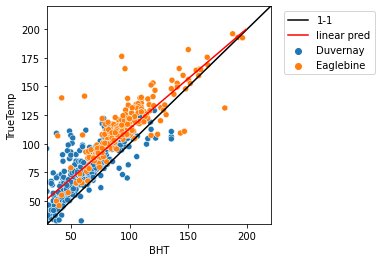

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=train, x="BHT", y="TrueTemp", hue='Field', ax=ax)

ax.set_xlim([30, 220])
ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220], label='1-1', c='k')

ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## 9.2 Use the linear regression model to predict on the validation set

In [61]:
test_data = pd.read_csv('val_data_no_label.csv')
test_data.head()

,Unnamed: 0_x,UWI,BHT,TrueTemp,Depth_SS(m),Field,TD (ft),Well_Id,Basin,TD_0,TD_1,TD_2,TD_3,TD_4,TD_5,TD_6,TD_7,TD_8,TD_9,TD_10,TD_11,TD_12,KB_0,KB_1,KB_2,KB_3,KB_4,KB_5,KB_6,KB_7,KB_8,KB_9,KB_10,KB_11,KB_12,Mud Wt_0,Mud Wt_1,Mud Wt_2,Mud Wt_3,Mud Wt_4,...,WellName,LogType,300.0_GRWS,600.0_GRWS,900.0_GRWS,1200.0_GRWS,14400.0_GRWS,14700.0_GRWS,15000.0_GRWS,15300.0_GRWS,15600.0_GRWS,15900.0_GRWS,16200.0_GRWS,16500.0_GRWS,16800.0_GRWS,17100.0_GRWS,17400.0_GRWS,17700.0_GRWS,18000.0_GRWS,18300.0_GRWS,18600.0_GRWS,18900.0_GRWS,19200.0_GRWS,19500.0_GRWS,19800.0_GRWS,20100.0_GRWS,20400.0_GRWS,20700.0_GRWS,21000.0_GRWS,21300.0_GRWS,21600.0_GRWS,21900.0_GRWS,22200.0_GRWS,22500.0_GRWS,22800.0_GRWS,23100.0_GRWS,23400.0_GRWS,23700.0_GRWS,24000.0_GRWS,Set
0,8,100012404516W502,93.33,NaN,2333.10,Duvernay,NaN,100012404516W502,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validation_Testing
1,10,100012805703W500,37.00,NaN,533.20,Duvernay,NaN,100012805703W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validation_Testing
2,16,100020206419W500,82.22,NaN,1742.80,Duvernay,NaN,100020206419W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validation_Testing
3,19,100020605904W500,78.89,NaN,1593.15,Duvernay,NaN,100020605904W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validation_Testing
4,20,100020606216W500,77.22,NaN,1411.35,Duvernay,NaN,100020606216W500,DV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validation_Testing


In [62]:
prediction = reg.predict(test_data['BHT'].values.reshape(-1, 1))

In [63]:
test_data['TrueTemp']=prediction

In [64]:
test_data[['UWI','TrueTemp']].to_csv('predictions.csv')

In [65]:
import zipfile
zipfile.ZipFile('predictions.zip', mode='w').write("predictions.csv")